In [126]:
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [71]:
data = pd.read_excel("타이타닉_data.xlsx",sheet_name="train")
test = pd.read_excel("타이타닉_data.xlsx",sheet_name="test")

In [9]:
data.head(10)

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,survival
0,2,"Lehmann, Miss. Bertha",Female,17,0,0,SC 1748,12.00,C,1
1,3,"Laitinen, Miss. Kristina Sofia",Female,37,0,0,4135,9.59,S,0
2,3,"Rosblom, Mr. Viktor Richard",Male,18,1,1,370129,20.21,S,0
3,3,"Karaic, Mr. Milan",Male,30,0,0,349246,7.90,S,0
4,3,"Moen, Mr. Sigurd Hansen",Male,25,0,0,348123,7.65,S,0
5,3,"Danoff, Mr. Yoto",Male,27,0,0,349219,7.90,S,0
6,3,"Peacock, Master. Alfred Edward",Male,1,1,1,SOTON/O.Q. 3101315,13.78,S,0
7,1,"Payne, Mr. Vivian Ponsonby",Male,23,0,0,12749,93.50,S,0
8,3,"Dennis, Mr. Samuel",Male,22,0,0,A/5 21172,7.25,S,0
9,2,"Brown, Miss. Amelia ""Mildred""",Female,24,0,0,248733,13.00,S,1


## 간단 탐색

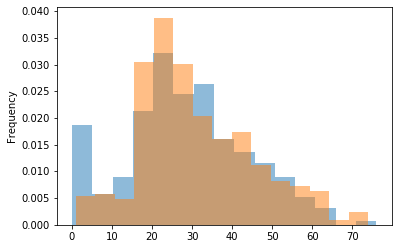

In [27]:
data[data["survival"]==1]["age"].plot.hist(bins=15,alpha=0.5,density=True)
data[data["survival"]==0]["age"].plot.hist(bins=15,alpha=0.5,density=True)

In [ ]:
## 0-16
## 16-30
## 30 -35
## 35-40
## 40-45
## 45-55
## 55-63
## 63-

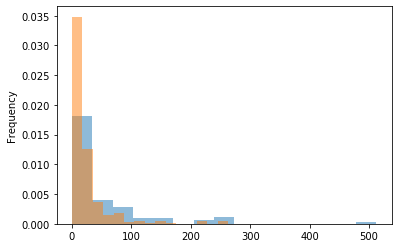

In [55]:
data[data["survival"]==1]["fare"].plot.hist(bins=15,alpha=0.5,density=True)
data[data["survival"]==0]["fare"].plot.hist(bins=15,alpha=0.5,density=True)

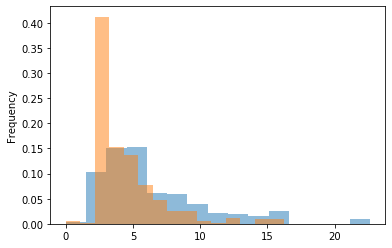

In [54]:
np.sqrt(data[data["survival"]==1]["fare"]).plot.hist(bins=15,alpha=0.5,density=True)
np.sqrt(data[data["survival"]==0]["fare"]).plot.hist(bins=15,alpha=0.5,density=True)
## sqrt scale 적용

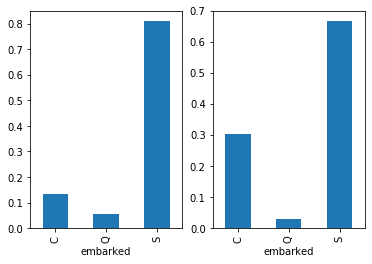

In [46]:
plt.subplot(121)
(data[data["survival"]==0].groupby("embarked").size()/data[data["survival"]==0].groupby("embarked").size().sum()).plot.bar()
plt.subplot(122)
(data[data["survival"]==1].groupby("embarked").size()/data[data["survival"]==1].groupby("embarked").size().sum()).plot.bar()

In [76]:
## cross 할만한 변수 찾기
data["plcass_embarked"]=data["pclass"].apply(lambda x:str(x))+"_" + data["embarked"]
test["plcass_embarked"]=test["pclass"].apply(lambda x:str(x))+"_" + test["embarked"]

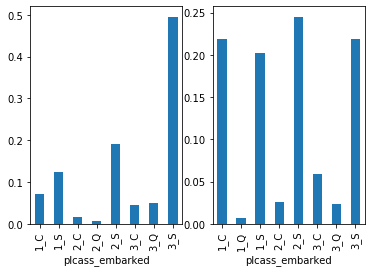

In [68]:
plt.subplot(121)
(data[data["survival"]==0].groupby("plcass_embarked").size()/data[data["survival"]==0].groupby("plcass_embarked").size().sum()).plot.bar()
plt.subplot(122)
(data[data["survival"]==1].groupby("plcass_embarked").size()/data[data["survival"]==1].groupby("plcass_embarked").size().sum()).plot.bar()

In [77]:
data["plcass_sex"]=data["pclass"].apply(lambda x:str(x))+"_" + data["sex"]
test["plcass_sex"]=test["pclass"].apply(lambda x:str(x))+"_" + test["sex"]


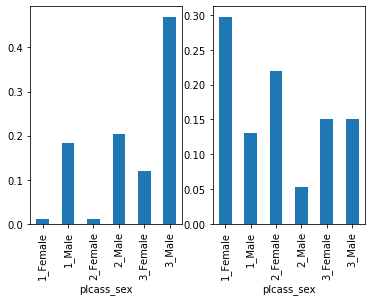

In [69]:
plt.subplot(121)
(data[data["survival"]==0].groupby("plcass_sex").size()/data[data["survival"]==0].groupby("plcass_sex").size().sum()).plot.bar()
plt.subplot(122)
(data[data["survival"]==1].groupby("plcass_sex").size()/data[data["survival"]==1].groupby("plcass_sex").size().sum()).plot.bar()

In [78]:
data["embarked_sex"]=data["embarked"]+"_" + data["sex"]
test["embarked_sex"]=test["embarked"]+"_" + test["sex"]


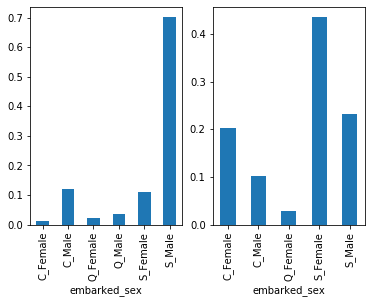

In [70]:
plt.subplot(121)
(data[data["survival"]==0].groupby("embarked_sex").size()/data[data["survival"]==0].groupby("embarked_sex").size().sum()).plot.bar()
plt.subplot(122)
(data[data["survival"]==1].groupby("embarked_sex").size()/data[data["survival"]==1].groupby("embarked_sex").size().sum()).plot.bar()

In [75]:
def df_to_dataset(dataframe,shuffle=True,batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('survival') # target변수 빼고 다시 데이터셋 구성
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe),labels)) # tf.data.Dataset은 Pandas 못받아들임 , dict형태로 변환    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [83]:
## 0-16
## 16-30
## 30 -35
## 35-40
## 40-45
## 45-55
## 55-63
## 63
data["pclass"] = data["pclass"].apply(lambda x:str(x))
test["pclass"] = test["pclass"].apply(lambda x:str(x))
data["fare"] = data["fare"].apply(lambda x:np.sqrt(x))
test["fare"] = test["fare"].apply(lambda x:np.sqrt(x))


In [82]:
data.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'embarked', 'survival', 'plcass_embarked', 'plcass_sex',
       'embarked_sex'],
      dtype='object')

In [142]:
tf.keras.backend.clear_session() # 전체 초기화

In [143]:
feature_columns = [] # 사용할 feature_column이 저장될 곳

feature_input = {}

# 수치형 열
for header in ['age', 'sibsp', 'parch',"fare"]:
    feature_columns.append(tf.feature_column.numeric_column(header))
    feature_input[header] = tf.keras.Input(shape=(1,),dtype=tf.float64,name=header)
    
# 버킷형 열
age_buckets = tf.feature_column.bucketized_column(feature_columns[0], boundaries=[16, 30, 35, 40, 45, 55, 63])

feature_columns.append(age_buckets)


# 범주형 열
cate_col=[]
for header in ["pclass","sex","embarked"]:
    cate_col.append(tf.feature_column.categorical_column_with_vocabulary_list(header, data[header].unique()))
    feature_input[header] = tf.keras.Input(shape=(1,),dtype=tf.string,name=header)


# 교차 특성 열
crossed_feature1 = tf.feature_column.crossed_column([cate_col[0], cate_col[1]], hash_bucket_size=4)#pclass sex
crossed_feature1 = tf.feature_column.embedding_column(crossed_feature1,dimension=2)
feature_columns.append(crossed_feature1)
crossed_feature2 = tf.feature_column.crossed_column([cate_col[1], cate_col[2]], hash_bucket_size=4) # sex embarked
crossed_feature2 = tf.feature_column.embedding_column(crossed_feature2,dimension=2)
feature_columns.append(crossed_feature2)
crossed_feature3 = tf.feature_column.crossed_column([cate_col[0], cate_col[2]], hash_bucket_size=4)# plcass embarked
crossed_feature3 = tf.feature_column.embedding_column(crossed_feature3,dimension=2)
feature_columns.append(crossed_feature3)



In [144]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns=feature_columns)

f_layer = feature_layer(feature_input)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [145]:
batch_size = 10
train,validation=train_test_split(data,test_size=0.3)
train_ds = df_to_dataset(train,batch_size=batch_size)
val_ds = df_to_dataset(validation,shuffle=False,batch_size=batch_size) # validation과 test는 셔플 할 필요가 없기에 패스
test_ds = df_to_dataset(test,shuffle=False,batch_size=batch_size) 

In [146]:
hidden1 = tf.keras.layers.Dense(128,activation="relu",dtype=tf.float64)(f_layer)
hidden2 = tf.keras.layers.Dense(128,activation="relu",dtype=tf.float64)(hidden1)
output = tf.keras.layers.Dense(1,activation="sigmoid",dtype=tf.float64)(hidden2)

In [147]:
Model=tf.keras.models.Model(inputs=feature_input,outputs=output)

In [148]:
Model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [153]:
history = Model.fit(train_ds,validation_data=val_ds,epochs=3)

Epoch 1/3
52/52 [==============================] - 2s 34ms/step - loss: 0.4647 - accuracy: 0.8023 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
52/52 [==============================] - 2s 40ms/step - loss: 0.4329 - accuracy: 0.7945 - val_loss: 0.4006 - val_accuracy: 0.8356
Epoch 3/3
52/52 [==============================] - 2s 39ms/step - loss: 0.4582 - accuracy: 0.7886 - val_loss: 0.4162 - val_accuracy: 0.8493


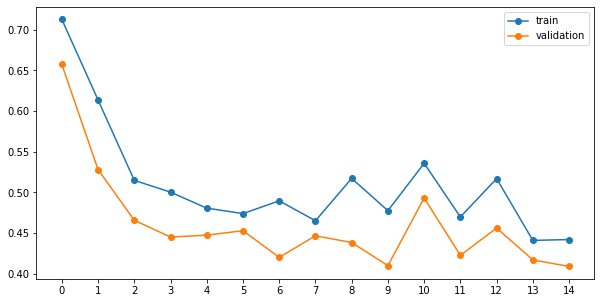

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.epoch,history.history["loss"],"o-",label="train")
plt.plot(history.epoch,history.history["val_loss"],"o-",label="validation")
plt.xticks(range(len(history.epoch)), history.epoch)
plt.legend()

In [154]:
loss, accuracy = Model.evaluate(test_ds)
print("정확도", accuracy)

32/32 [==============================] - 0s 13ms/step - loss: 0.4726 - accuracy: 0.8051
정확도 0.8051118


In [120]:
## 학습한 model 구조 json 형태로 저장
model_json = Model.to_json()
with open("Model_titanic.json","w") as json_file:
    json_file.write(model_json)

In [121]:
## 학습한 model weight 저장 .h5 형태
Model.save_weights("Model_titanic.h5")
print("Saved model to disk")

Saved model to disk


In [158]:
json_file = open("Model_titanic.json","r")
load_model = json_file.read()
json_file.close()
load_model = tf.keras.models.model_from_json(load_model)

In [160]:
load_model.load_weights("Model_titanic.h5")
print("Load model from disk")

Load model from disk


In [162]:
load_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
load_model.evaluate(test_ds)

32/32 [==============================] - 1s 38ms/step - loss: 0.4423 - accuracy: 0.8211


[0.4422937553637894, 0.8210863]